<a href="https://colab.research.google.com/github/Agrover112/DL_Implementations/blob/master/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 11.8 MB/s 
     |████████████████████████████████| 376 kB 54.9 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=837cef9bd27ead196fb4bf81786c61c0a747fd257a2ee233f6e4416ea1a54ec5
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=7dd918cb5732c3913051beba6f0cf7a0fb153dfbe7733445001422bc8afed4ce
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning h

# About Dataset

### Dataset

Here the dataset which we are going to use in this  project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset Link

https://www.cs.toronto.edu/~vmnih/data/



# Downloading the dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Importing

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm



# Setup configurations

In [ ]:
CSV_FILE='/content/Road_seg_dataset/train.csv'
DATA_DIR='/content/Road_seg_dataset/'

DEVICE='cuda'

EPOCHS=25
LR= 0.003

BATCH_SIZE= 8
IMG_SIZE =512

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head(5)

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
image_path=DATA_DIR+ df.images[69]
mask_path=DATA_DIR+ df.masks[69]

image=cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255

In [ ]:
print(image_path)

/content/Road_seg_dataset/images/18328900_15.png


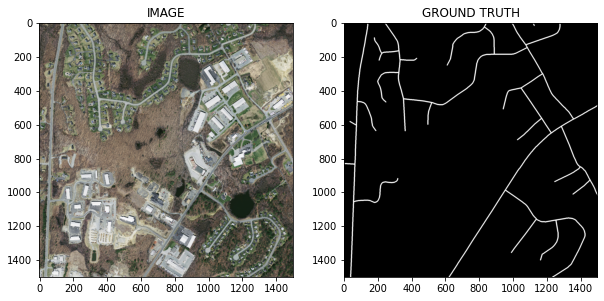

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2, random_state=42)

In [ ]:
len(train_df),len(valid_df)

(159, 40)

# Define the Augmentation functions

*albumentation* documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch


def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.squeeze(),cmap = 'gray')
        
        


In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(512,512),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(512,512),
                    
  ])

# Create Custom Dataset class

In [ ]:
from torch.utils.data import Dataset 

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks
    #print(image_path)
    image = cv2.imread(image_path)
    #print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations is not None:
      data = self.augmentations(image = image, mask = mask)

      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [ ]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(" size of trainset {}".format(len(trainset)))
print(" size of trainset {}".format(len(validset)))

 size of trainset 159
 size of trainset 40


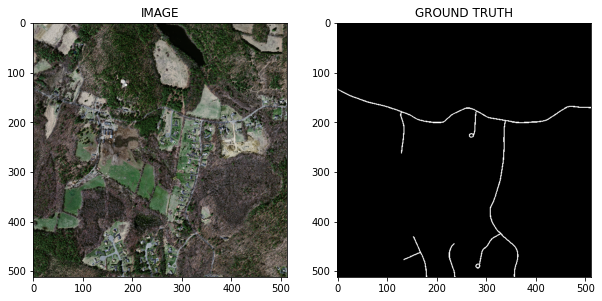

In [ ]:
idx = 3
image, mask =trainset[idx]
show_image(image,mask)


# Defining DataLoaders

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
print(len(trainloader),len(validloader))

20 5



*   160/8 =20 batches each of 8 images of format --> (No. of Images & Corressponding Mask in a batch , NC,H,W)



In [ ]:
for images,mask in trainloader:
  print("One batch image shape: {} and One batch Mask Shape: {}".format(images.shape,mask.shape))

One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8, 3, 512, 512]) and One batch Mask Shape: torch.Size([8, 1, 512, 512])
One batch image shape: torch.Size([8,

# Defining our model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone =smp.Unet(encoder_name =ENCODER,encoder_weights=WEIGHTS,in_channels=3,classes=1,activation= None)
    
  
  def forward(self,images,masks=None):
    logits=self.backbone(images)
    if masks!=None: # Training mode 
        return logits, DiceLoss(mode='binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits,masks)  # F1 Coefficient + CrossEntropyLosswithSoftmax (scalars)  # Dice is derived from IoU 
    
    return logits #output without final regression head (softmax/sigmoid)

In [ ]:
model=SegmentationModel()
model.to(DEVICE)

In [ ]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


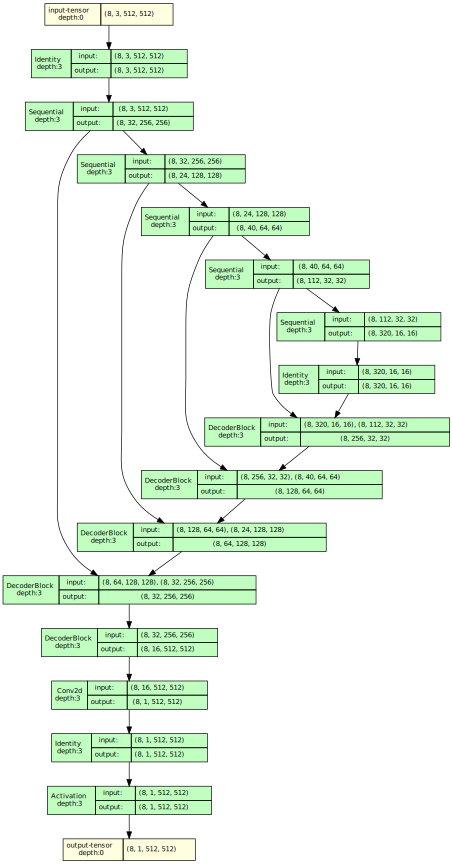

In [ ]:
from torchview import draw_graph

batch_size = 2
# device='meta' -> no memory is consumed during for visualization
model_graph = draw_graph(model, input_size=(8,3,512,512), device=DEVICE)
model_graph.visual_graph

# Validation and Training Inner Loops

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train()  

  total_loss=0.0

  for images,masks in tqdm(dataloader):

    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model.forward(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader) # total_loss /no.of batches




In [ ]:
def eval_fn(dataloader, model):
  model.eval()

  total_loss=0.0
  with torch.no_grad():

    for images,masks in tqdm(dataloader):

      images=images.to(DEVICE)
      masks=masks.to(DEVICE)
      logits,loss=model.forward(images,masks)
      total_loss+=loss.item()

    return total_loss/len(dataloader) # total_loss /no.of batches




# Outer Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# Training loop which calls the inner loop which basically is for every batch
best_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("Model saved {}th time".format(i))
    best_loss=valid_loss
  
  print("Epoch {} Train Loss: {} Validation Loss : {}".format(i+1,train_loss,valid_loss))

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Model saved 0th time
Epoch 1 Train Loss: 0.552812571823597 Validation Loss : 0.6306816101074219


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Model saved 1th time
Epoch 2 Train Loss: 0.5409570693969726 Validation Loss : 0.6145478248596191


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 3 Train Loss: 0.5496287420392036 Validation Loss : 0.6265157461166382


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Model saved 3th time
Epoch 4 Train Loss: 0.5445411145687103 Validation Loss : 0.6026044487953186


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 5 Train Loss: 0.5458417102694512 Validation Loss : 0.6121159672737122


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Model saved 5th time
Epoch 6 Train Loss: 0.5362842917442322 Validation Loss : 0.6006564259529114


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 7 Train Loss: 0.5306729838252068 Validation Loss : 0.6123055458068848


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 8 Train Loss: 0.5284529075026512 Validation Loss : 0.6219753861427307


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Model saved 8th time
Epoch 9 Train Loss: 0.5292444437742233 Validation Loss : 0.5963131010532379


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 10 Train Loss: 0.523765715956688 Validation Loss : 0.6519949078559876


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 11 Train Loss: 0.5271729797124862 Validation Loss : 0.6008680105209351


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 12 Train Loss: 0.533829978108406 Validation Loss : 0.6292883038520813


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 13 Train Loss: 0.5271734982728958 Validation Loss : 0.6048197329044342


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 14 Train Loss: 0.5241141602396965 Validation Loss : 0.6200065732002258


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 15 Train Loss: 0.516598230600357 Validation Loss : 0.6022974848747253


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 16 Train Loss: 0.5230062156915665 Validation Loss : 0.601394248008728


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 17 Train Loss: 0.5167606368660926 Validation Loss : 0.6037086129188538


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 18 Train Loss: 0.5157330051064491 Validation Loss : 0.5967801928520202


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 19 Train Loss: 0.508683331310749 Validation Loss : 0.6067104578018189


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 20 Train Loss: 0.5138147503137589 Validation Loss : 0.6145501971244812


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 21 Train Loss: 0.5116923421621322 Validation Loss : 0.6502800583839417


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 22 Train Loss: 0.5150682896375656 Validation Loss : 0.6005226731300354


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Model saved 22th time
Epoch 23 Train Loss: 0.5124423921108245 Validation Loss : 0.5954618096351624


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Model saved 23th time
Epoch 24 Train Loss: 0.5134058177471161 Validation Loss : 0.5874411702156067


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Model saved 24th time
Epoch 25 Train Loss: 0.5049926146864891 Validation Loss : 0.5837291121482849


# Inference

In [ ]:
idx=4

model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) to (b,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask >0.5)*1.0

In [ ]:
pred_mask.shape

torch.Size([1, 1, 512, 512])

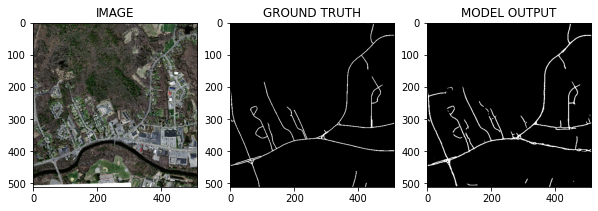

In [ ]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))